In [1]:
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pylab as plt 
import matplotlib.lines as mlines
from matplotlib.legend import Legend
from pythonds.basic.stack import Stack
from math import *
from sklearn.neighbors import KDTree
from lrg_plot_functions import *
from lrg_sum_functions import *
from cosmo_Calc import *
from divideByTwo import *
# from read_data import *
from nearNeighbors import *
from scipy import stats
from astropy import stats
import healpy as hp
from localBKG_and_interlopersHEALPix import *
# import healpy as hpy
from makeCutoutTableFunc import *
from plotHistogramProjections3D import *
from read_bricks import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from astropy.table import Table, hstack
from scipy.spatial import cKDTree as KDTree

In [2]:
# read BKG data arrays

data_raBKG = np.load('/Users/mtownsend/anaconda/Data/ra_BKG_v2.npz')
raBKG = data_raBKG['ra_BKG']
print(raBKG.shape)

print('----')

data_decBKG = np.load('/Users/mtownsend/anaconda/Data/dec_BKG_v2.npz')
decBKG = data_decBKG['dec_BKG']
print(decBKG.shape)

print('----')

data_gmagBKG = np.load('/Users/mtownsend/anaconda/Data/gmag_BKG_v2.npz')
gmagBKG = data_gmagBKG['gmag_BKG']
print(gmagBKG.shape)

print('----')

data_rmagBKG = np.load('/Users/mtownsend/anaconda/Data/rmag_BKG_v2.npz')
rmagBKG = data_rmagBKG['rmag_BKG']
print(rmagBKG.shape)

print('----')

data_zmagBKG = np.load('/Users/mtownsend/anaconda/Data/zmag_BKG_v2.npz')
zmagBKG = data_zmagBKG['zmag_BKG']
print(zmagBKG.shape)

print('----')


data_grcolorBKG = np.load('/Users/mtownsend/anaconda/Data/grcolor_BKG_v2.npz')
grcolorBKG = data_grcolorBKG['grcolor_BKG']
print(grcolorBKG.shape)

print('----')

data_rzcolorBKG = np.load('/Users/mtownsend/anaconda/Data/rzcolor_BKG_v2.npz')
rzcolorBKG = data_rzcolorBKG['rzcolor_BKG']
print(rzcolorBKG.shape)


(1294476,)
----
(1294476,)
----
(1294476,)
----
(1294476,)
----
(1294476,)
----
(1294476,)
----
(1294476,)


In [3]:
# read LRG data arrays

data_raLRG = np.load('/Users/mtownsend/anaconda/Data/ra_LRG.npz')
raLRG = data_raLRG['ra_LRG']
print(raLRG.shape)

print('----')

data_decLRG = np.load('/Users/mtownsend/anaconda/Data/dec_LRG.npz')
decLRG = data_decLRG['dec_LRG']
print(decLRG.shape)

print('----')

data_zLRG = np.load('/Users/mtownsend/anaconda/Data/z_LRG.npz')
zLRG = data_zLRG['z_LRG']
print(zLRG.shape)

print('----')

data_gmagLRG = np.load('/Users/mtownsend/anaconda/Data/gmag_LRG.npz')
gmagLRG = data_gmagLRG['gmag_LRG']
print(gmagLRG.shape)

print('----')

data_rmagLRG = np.load('/Users/mtownsend/anaconda/Data/rmag_LRG.npz')
rmagLRG = data_rmagLRG['rmag_LRG']
print(rmagLRG.shape)

print('----')

data_zmagLRG = np.load('/Users/mtownsend/anaconda/Data/zmag_LRG.npz')
zmagLRG = data_zmagLRG['zmag_LRG']
print(zmagLRG.shape)
print(zmagLRG.min())
print(zmagLRG.max())

print('----')

data_grcolorLRG = np.load('/Users/mtownsend/anaconda/Data/grcolor_LRG.npz')
grcolorLRG = data_grcolorLRG['grcolor_LRG']
print(grcolorLRG.shape)

print('----')

data_rzcolorLRG = np.load('/Users/mtownsend/anaconda/Data/rzcolor_LRG.npz')
rzcolorLRG = data_rzcolorLRG['rzcolor_LRG']
print(rzcolorLRG.shape)



(1823,)
----
(1823,)
----
(1823,)
----
(1823,)
----
(1823,)
----
(1823,)
15.818878
21.957382
----
(1823,)
----
(1823,)


### LRG Mass

In [4]:
def read_isedfit():
    """Read the iSEDfit fitting results."""
    
#     parentfile = '/Users/mtownsend/anaconda/Data/lrg-survey-dr8-try5.fits'
    isedfile = '/Users/mtownsend/Downloads/lrgs_dr8_ckc14z_kroupa01_charlot_sfhgrid01.fits'
#     kcorrfile = '/Users/mtownsend/anaconda/Data/lrgs_ckc14z_kroupa01_charlot_sfhgrid01_kcorr.z0.0.fits'

#     print('Reading {}'.format(parentfile))
#     parent = Table.read(parentfile)
    print('Reading {}'.format(isedfile))
    ised = Table.read(isedfile)
#     print('Reading {}'.format(kcorrfile))
#     kcorr = Table.read(kcorrfile)
    
    snrmin = 3.0
    chi2min = 10
    
    keep = np.where(
        (ised['CHI2'] < chi2min) * 
        (np.sum(ised['MAGGIES'] * np.sqrt(ised['IVARMAGGIES']) > snrmin, axis=1) == 5)
    )[0]
    print('Read {} galaxies with chi2 < {} and S/N > {} in all 5 photometric bands.'.format(
        len(keep), chi2min, snrmin))
    
#     cat = dict()
#     cat['weight'] = len(keep) * parent['COUNT'][keep].data / np.sum(parent['COUNT'][keep].data)
#     cat['redshift'] = kcorr['Z'][keep].data
#     cat['Mstar'] = ised['MSTAR_50'][keep].data
#     cat['Mg'] = kcorr['ABSMAG'][keep, 0].data
#     cat['Mr'] = kcorr['ABSMAG'][keep, 1].data
#     cat['Mz'] = kcorr['ABSMAG'][keep, 2].data
#     cat['gr'] = cat['Mg'] - cat['Mr']
#     cat['rz'] = cat['Mr'] - cat['Mz']

#     with np.errstate(invalid='ignore'):
#         cat['grobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 0].data / ised['MAGGIES'][keep, 1].data )
#         cat['rzobs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 1].data / ised['MAGGIES'][keep, 2].data )
#         cat['zW1obs'] = -2.5 * np.log10( ised['MAGGIES'][keep, 2].data / ised['MAGGIES'][keep, 3].data )
     
    #mm = - 2.5 * np.log10(ised['MAGGIES'][keep, 0].data)
    #_ = plt.hist(mm, bins=100)
    
#     kcorr.remove_columns(['Z', 'ISEDFIT_ID', 'MAGGIES', 'IVARMAGGIES'])
    out = hstack([ised])
    
    return out

In [5]:
ised = read_isedfit()
ngal = len(ised)

Reading /Users/mtownsend/Downloads/lrgs_dr8_ckc14z_kroupa01_charlot_sfhgrid01.fits
Read 740800 galaxies with chi2 < 10 and S/N > 3.0 in all 5 photometric bands.


In [6]:
print(type(ised))

mstar = np.array(ised['MSTAR_50'])
print(type(mstar))
total_mass = np.array(ised['TOTALMASS'])

ra_MOUS = np.array(ised['RA'])
dec_MOUS = np.array(ised['DEC'])
mstar_err = np.array(ised['MSTAR_ERR'])
z_MOUS = np.array(ised['Z'])
print(len(ra_MOUS))
print(len(z_MOUS))

print(len(mstar[np.where((ra_MOUS >= 241.) & (ra_MOUS <=246.) & (dec_MOUS >= 6.5) & (dec_MOUS <= 11.5))]))

<class 'astropy.table.table.Table'>
<class 'numpy.ndarray'>
1078965
1078965
2007


In [7]:
from astropy.coordinates import SkyCoord, match_coordinates_sky                                   
from astropy import units as u       

mous_cat = SkyCoord(ra=ra_MOUS*u.degree, dec=dec_MOUS*u.degree)                          

my_cat = SkyCoord(ra=raLRG*u.degree, dec=decLRG*u.degree)                                

idx, sep2d, dist3d = match_coordinates_sky(my_cat, mous_cat, nthneighbor=1)
# idx, sep2d, dist3d = my_cat.match_to_catalog_sky(mous_cat)

print(raLRG[1])
print(ra_MOUS[idx[1]])

print(decLRG[1])
print(dec_MOUS[idx[1]])

mass_LRG = mstar[idx]
print(len(mass_LRG))

ra_cut = ra_MOUS[np.where((z_MOUS >= 0.2) & (z_MOUS <= 0.65) & (ra_MOUS >= 241) & (ra_MOUS <= 246) & (dec_MOUS >= 6.5) & (dec_MOUS <= 11.5))]
dec_cut = dec_MOUS[np.where((z_MOUS >= 0.2) & (z_MOUS <= 0.65) & (ra_MOUS >= 241) & (ra_MOUS <= 246) & (dec_MOUS >= 6.5) & (dec_MOUS <= 11.5))]
print(len(ra_cut))
print(len(ra_MOUS))


241.05811624717717
241.05811624717717
9.243933417459095
9.243933417459095
1823
1823
1078965


/Users/mtownsend/anaconda/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


11.395743
11.396393
6222
1078963
1078965
8.540206


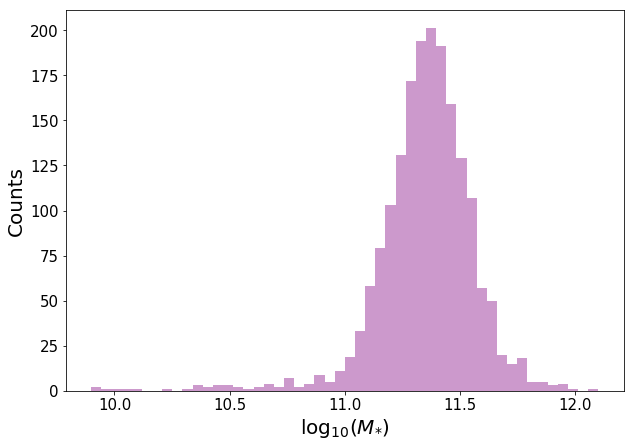

In [9]:
import pandas as pd
import seaborn as sns


import seaborn as sns

plt.rcParams["figure.figsize"] = [10, 7]
# plt.rc('text', usetex=True)
sns.distplot(mass_LRG, kde=False, color='purple')
# plt.title('LRG Mass Distribution', fontsize=25)
plt.xlabel('$\log_{10}(M_{*})$', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.xlim(10., 12.5)
# plt.savefig('/Users/mtownsend/Desktop/LRGmass-dist-EDR_nolables.pdf')
# plt.savefig('/Users/mtownsend/Desktop/NewPaperPlots/LRGmass-dist-EDR_v1.jpg')

print(np.mean(mstar))
print(np.median(mstar))

mstar_full = mstar[np.where(mstar > 0.)]
print(len(mstar_full[np.where(mstar < 10.75)]))
print(len(mstar_full))
print(len(mstar))
print(min(mstar_full))

### LRG Redshift

1823


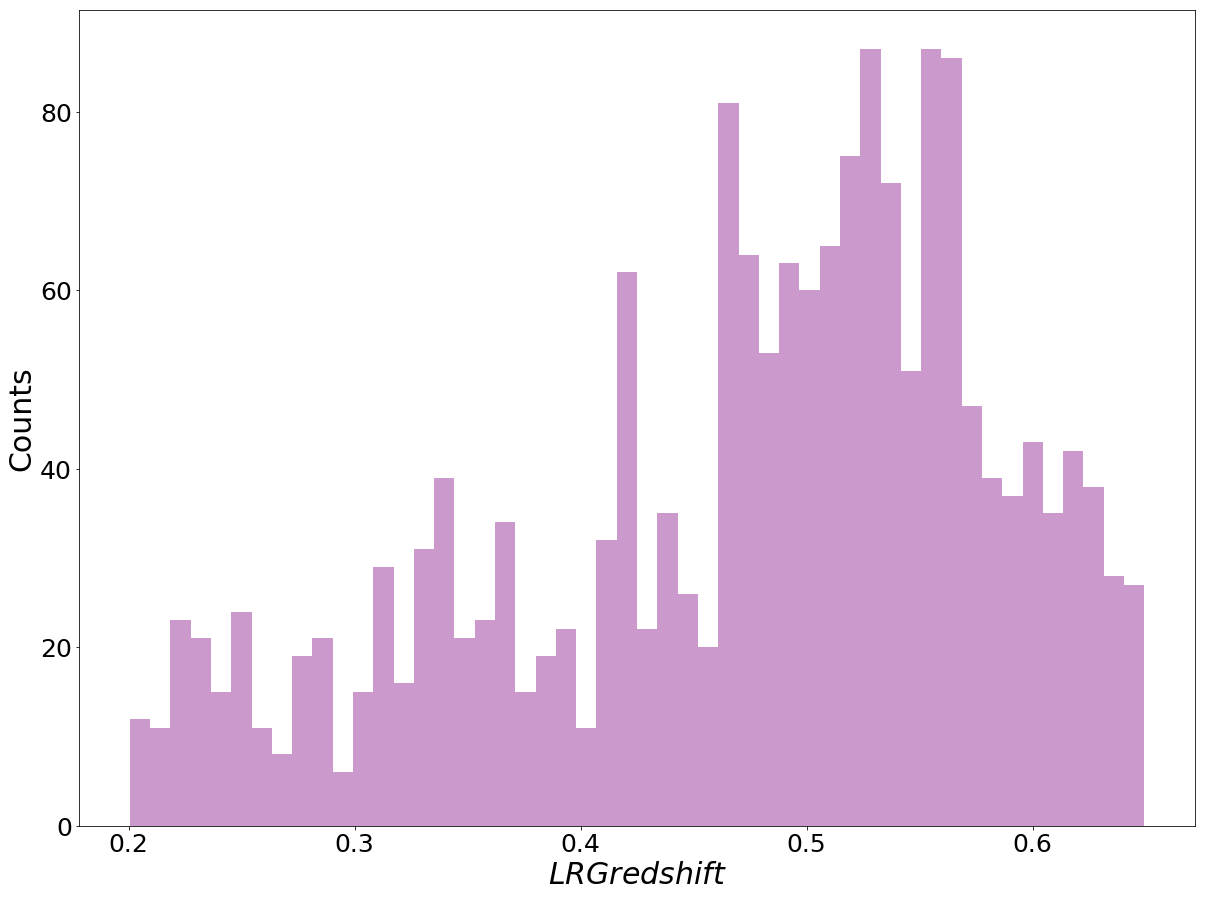

In [10]:
print(len(zLRG))

import seaborn as sns

plt.rcParams["figure.figsize"] = [20, 15]
sns.distplot(zLRG, bins=50, kde=False, color='purple')
# plt.title('LRG Mr Distribution, Mr > -20.5', fontsize=25)
plt.xlabel('$LRG$$redshift$', fontsize=30)
plt.ylabel('Counts', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=25)
# plt.gca().invert_xaxis()
# plt.savefig('/Users/mtownsend/Desktop/LRG_Mr_dist_faint_v1.jpg')
# plt.savefig('/Users/mtownsend/Desktop/NewPaperPlots/LRG_Mr_dist-v1.pdf')

### LRG absolute r-band magnitudes

In [11]:
# read in EAZY outputs
# only need 3rd, 6th, and 7th columns

# use for Mr and (Mg-Mr) color

data = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/LRG_OUTPUT/LRG_main_output.295-297.rf', 'r')
# data = open('/Users/mtownsend/eazy-photoz/inputs/OUTPUT/UVISTA_master_v4.1/UVISTA_master_v4.1.80-81.rf', 'r')
lines = data.readlines()[11:]

# print(lines)

z = []
DM = []
L_rfilter = []
L_zfilter = []

for line in lines:
    p = line.split()
    z.append(float(p[1]))
    DM.append(float(p[2]))
    L_rfilter.append(float(p[5]))
    L_zfilter.append(float(p[6]))
    
print(len(DM))
print(DM[0])
print(len(L_rfilter))
print(len(L_zfilter))
# print(type(z[0]))
# zarr = np.array(z)

DM_arr = np.array(DM)
L_rfilter_arr = np.array(L_rfilter)
L_zfilter_arr = np.array(L_zfilter)

1823
39.88
1823
1823


In [12]:
# calculate rest-frame magnitudes

K_correct = -2.5*np.log10((1. + zLRG)**-1.)
print(len(K_correct))
# print(len(zphot[np.where(zmag <= 22.36)]))
# print(len(rmag_LRG[np.where(zmag_LRG <= 22.36)]))

Mr = rmagLRG - DM_arr - K_correct
print(len(Mr))
Mz = zmagLRG - DM_arr - K_correct

1823
1823


-22.354355057809812
-22.38792870759964


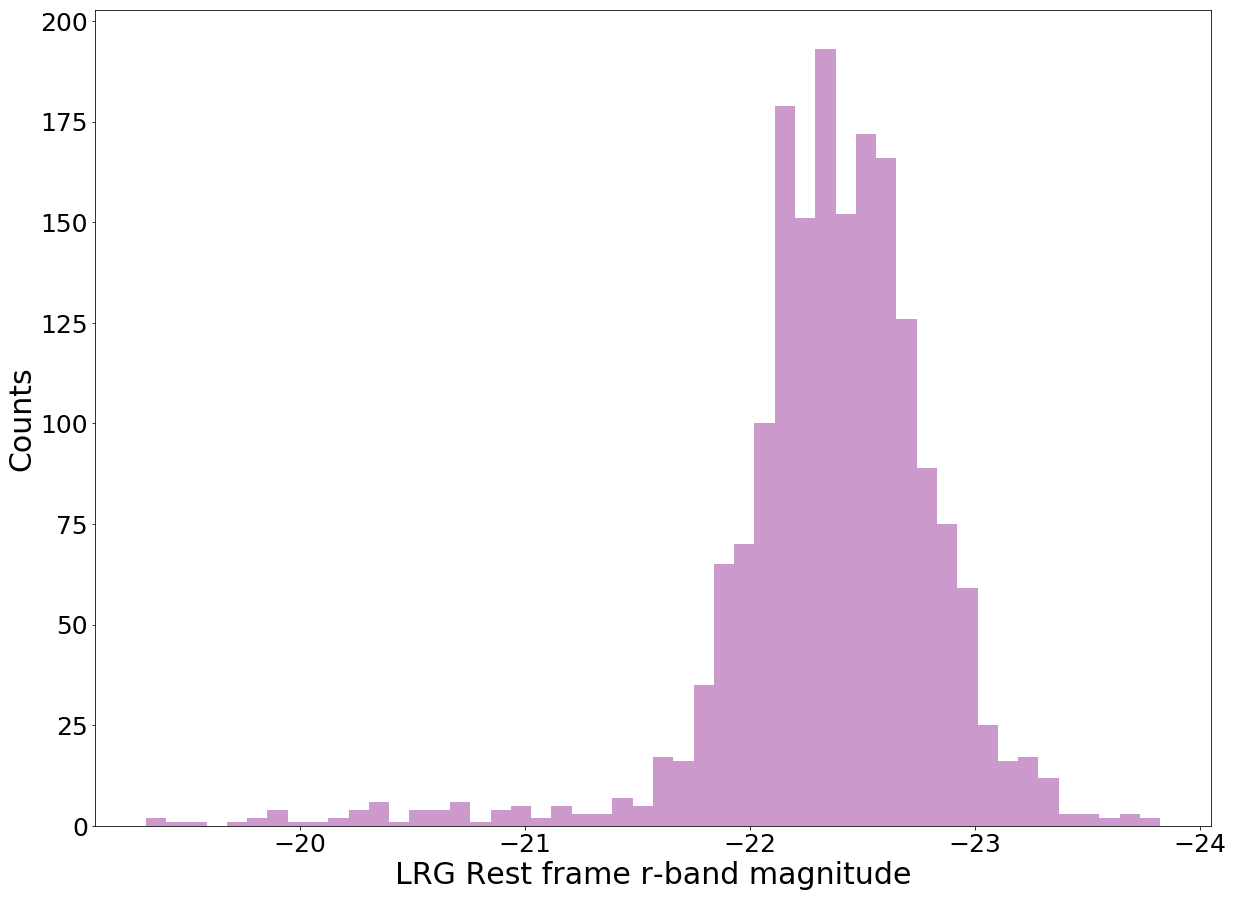

In [13]:
# Plot rest frame r magnitudes
import seaborn as sns

plt.rcParams["figure.figsize"] = [20, 15]
sns.distplot(Mr, bins=50, kde=False, color='purple')
# plt.title('LRG Mr Distribution, Mr > -20.5', fontsize=25)
plt.xlabel('LRG Rest frame r-band magnitude', fontsize=30)
plt.ylabel('Counts', fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.gca().invert_xaxis()
# plt.savefig('/Users/mtownsend/Desktop/LRG_Mr_dist_faint_v1.jpg')
# plt.savefig('/Users/mtownsend/Desktop/NewPaperPlots/LRG_Mr_dist-v1.pdf')

print(np.mean(Mr))
print(np.median(Mr))

[Text(0,0.5,'Counts'), Text(0.5,0,'$\\log_{10}(M_{*})$')]

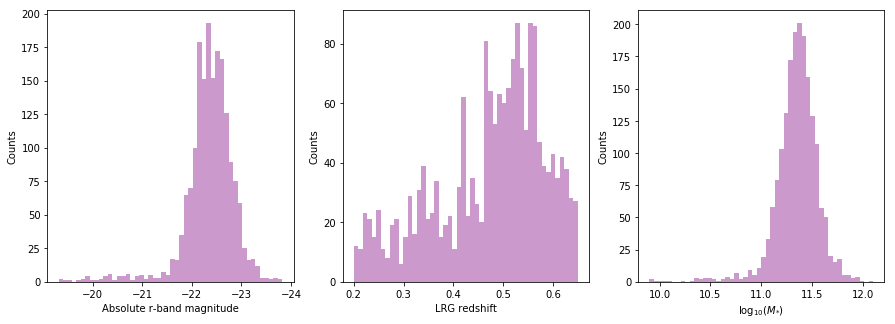

In [14]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15,5))

a = sns.distplot(Mr, bins=50, ax=axes[0], kde=False, color='purple')
# plt.xlabel('Absolute r-band magnitude', fontsize=15)
# plt.ylabel('Absolute r-band magnitude', fontsize=15)
# plt.tick_params(axis='both', which='major', labelsize=10)
a.invert_xaxis()
a.set(xlabel ="Absolute r-band magnitude", ylabel = "Counts")

b = sns.distplot(zLRG, bins=50, ax=axes[1], kde=False, color='purple')
# plt.xlabel('$LRG$$redshift$', fontsize=15)
# plt.ylabel('Counts', fontsize=15)
# plt.tick_params(axis='both', which='major', labelsize=10)
b.set(xlabel ="LRG redshift", ylabel = "Counts")

c = sns.distplot(mass_LRG, kde=False, ax=axes[2], color='purple')
# plt.title('LRG Mass Distribution', fontsize=25)
# plt.xlabel('$\log_{10}(M_{*})$', fontsize=15)
# plt.ylabel('Counts', fontsize=15)
# plt.tick_params(axis='both', which='major', labelsize=10)
c.set(xlabel ="$\log_{10}(M_{*})$", ylabel = "Counts")

# plt.savefig('/Users/mtownsend/Desktop/PaperPlots/LRG-info.pdf')


### BKG observed zmag distribution

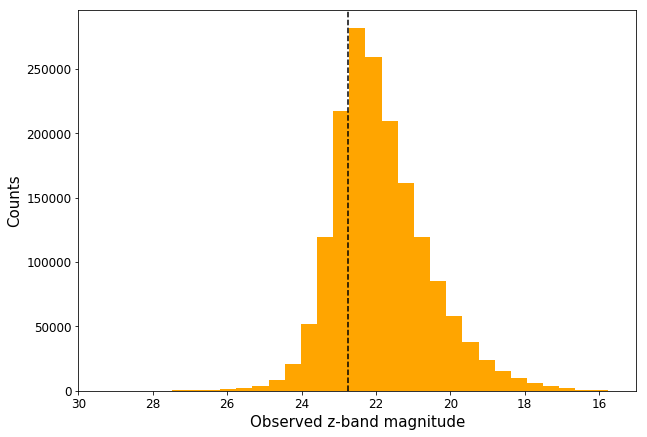

In [15]:
data_zmagBKG = np.load('/Users/mtownsend/anaconda/Data/zmag_BKG_nocut.npz')
zmagBKG = data_zmagBKG['zmag_BKG']

plt.rcParams["figure.figsize"] = [10, 7]
plt.hist(zmagBKG, bins=50, color='orange')
# plt.title("Median 5-sigma source detection zmag in each HP pixel")
plt.axvline(22.75, c='black', ls='--')
plt.xlim(15, 30)
plt.xlabel('Observed z-band magnitude', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.gca().invert_xaxis()
# plt.savefig('/Users/mtownsend/Desktop/PaperPlots/BKG-observed-zmag.pdf')

plt.show()

### BKG before and after zmag cut

1294476
1699962
1294476
1699962


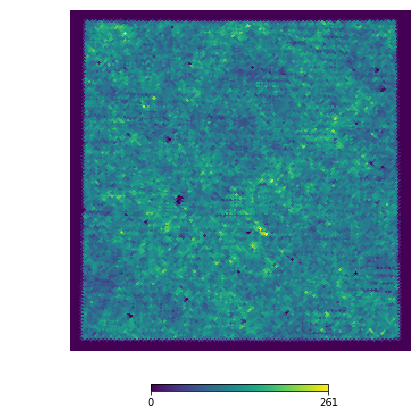

length phi:  1699962
end making HEALPix map


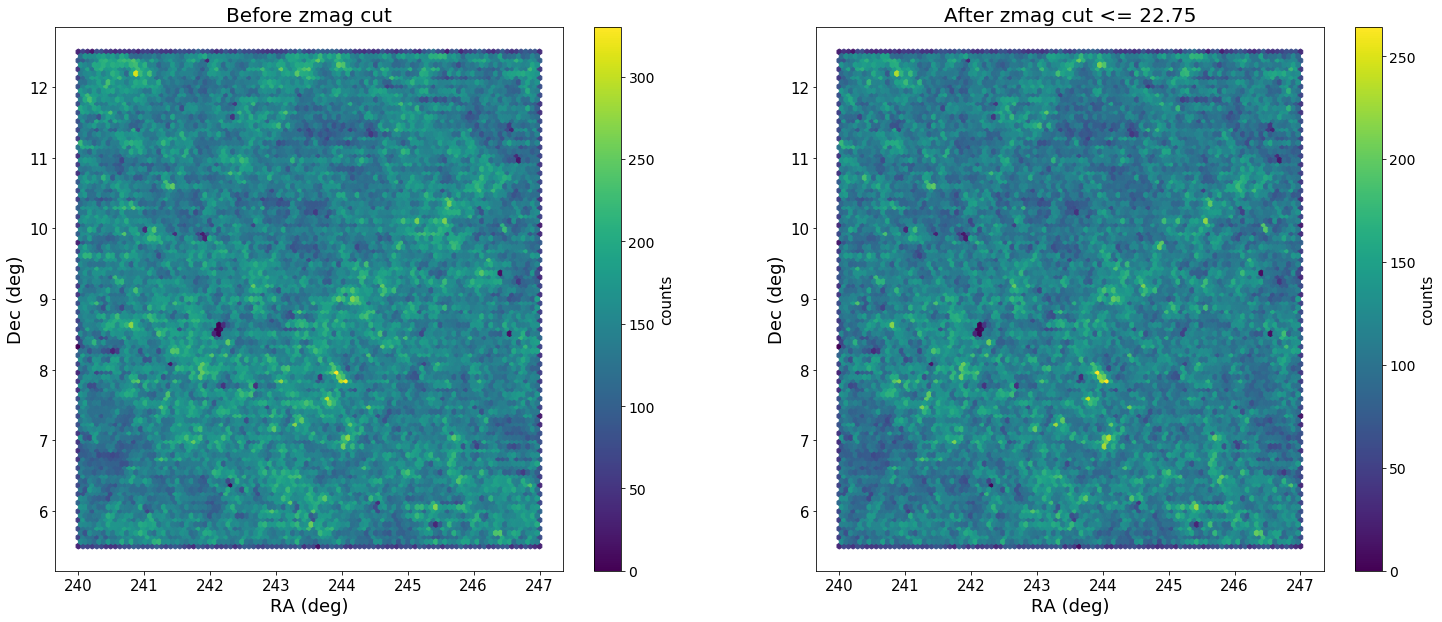

In [44]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt 
import healpy as hp
import skymapper as skm

data_raBKG_nocut = np.load('/Users/mtownsend/anaconda/Data/ra_BKG_nocut.npz')
raBKG_nocut = data_raBKG_nocut['ra_BKG']

data_decBKG_nocut = np.load('/Users/mtownsend/anaconda/Data/dec_BKG_nocut.npz')
decBKG_nocut = data_decBKG_nocut['dec_BKG']

print(len(raBKG))
print(len(raBKG_nocut))
print(len(decBKG))
print(len(decBKG_nocut))

# Make HEALPix map using just RA/Dec; end up with a density plot

nside = 1024
npixel = hp.nside2npix(nside)

# Convert ra/dec into theta/phi
theta = []
phi = []

for i in range(len(raBKG_nocut)):
    theta.append(np.radians(90. - decBKG_nocut[i]))
    phi.append(np.radians(raBKG_nocut[i]))
    
m = hp.ang2pix(nside, theta, phi)
map_ = np.bincount(m, minlength=npixel)
c = hp.gnomview(map_, xsize=300, rot=(-116.5, 9), flip='geo', cmap='viridis', notext=True, title="")
# plt.rcParams.update({'font.size':20})
plt.xlabel('Observed z-band magnitude', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=12)
# plt.savefig('/Users/mtownsend/Desktop/survey-density.jpg')
# plt.savefig('/Users/mtownsend/Desktop/MeetingPlots/HEALPix-survey-density-v2.pdf')
plt.show()

print('length phi: ', len(phi))

# Convert angles theta and phi to pixel numbers

pixnums = hp.ang2pix(nside, theta, phi, nest=True)
print('end making HEALPix map')


fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(25,10))
nbins = 100
axes[0].set_title('Before zmag cut', fontsize=20)
hb0 = axes[0].hexbin(raBKG_nocut, decBKG_nocut, gridsize=nbins, cmap='viridis')
axes[0].set_xlabel('RA (deg)', fontsize=18)
axes[0].set_ylabel('Dec (deg)', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=15)
cb0 = fig.colorbar(hb0, ax=axes[0])
cb0.set_label('counts', fontsize=15)
cb0.ax.tick_params(labelsize=14)

axes[1].set_title('After zmag cut <= 22.75', fontsize=20)
hb1 = axes[1].hexbin(raBKG, decBKG, gridsize=nbins, cmap='viridis')
axes[1].set_xlabel('RA (deg)', fontsize=18)
axes[1].set_ylabel('Dec (deg)', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=15)
cb1 = fig.colorbar(hb1, ax=axes[1])
cb1.set_label('counts', fontsize=15)
cb1.ax.tick_params(labelsize=14)

plt.savefig('/Users/mtownsend/Desktop/PaperPlots/BKG-before-and-after-zmag-cut.jpg')

plt.show()


# longitude = np.radians(np.linspace(-180, 180, 2000))
# latitude = np.radians(np.linspace(-90, 90, 1000))

# # project the map to a rectangular matrix xsize x ysize
# PHI, THETA = np.meshgrid(phi, theta)
# grid_pix = hp.ang2pix(nside, THETA, PHI)
# grid_map = m[grid_pix]

# fig = plt.figure(figsize=(10, 10))
# # matplotlib is doing the mollveide projection
# ax = fig.add_subplot(111,projection='mollweide')


# # rasterized makes the map bitmap while the labels remain vectorial
# # flip longitude to the astro convention
# image = plt.pcolormesh(longitude[::-1], latitude, grid_map, cmap='viridis', rasterized=True) # vmin=vmin, vmax=vmax, rasterized=True, cmap=cmap)

# # graticule
# ax.set_longitude_grid(60)

# # colorbar
# cb = fig.colorbar(image, orientation='horizontal', shrink=.6, pad=0.05, ticks=[vmin, vmax])
# cb.ax.xaxis.set_label_text(unit)
# cb.ax.xaxis.labelpad = -8
# # workaround for issue with viewers, see colorbar docstring
# cb.solids.set_edgecolor("face")

# ax.tick_params(axis='x', labelsize=10)
# ax.tick_params(axis='y', labelsize=10)

# # remove tick labels
# ax.xaxis.set_ticklabels([])
# ax.yaxis.set_ticklabels([])
# # remove grid
# ax.xaxis.set_ticks([])
# ax.yaxis.set_ticks([])

# # remove white space around figure
# spacing = 0.01
# plt.subplots_adjust(bottom=spacing, top=1-spacing, left=spacing, right=1-spacing)

# plt.grid(True)



In [12]:
# lowz
# masked_Nsat_low35 = Nsat_bin1_new * low_smatrix35

# np.savez('/Users/mtownsend/Documents/LRG_Data/masked_Nsat_low-EDR.npz', masked_Nsat_low35=masked_Nsat_low35)
data_Nsat_low = np.load('/Users/mtownsend/Documents/LRG_Data/masked_Nsat_low-EDR.npz')
Nsat35_low = data_Nsat_low['masked_Nsat_low35']
print(len(Nsat35_low))

# midz
# masked_Nsat_mid35 = Nsat_bin1_new * mid_smatrix35
# masked_Nsat_mid05 = Nsat_bin2_new * mid_smatrix05

# np.savez('/Users/mtownsend/Documents/LRG_Data/masked_Nsat_mid-EDR.npz', masked_Nsat_mid35=masked_Nsat_mid35, masked_Nsat_mid05=masked_Nsat_mid05)
data_Nsat_mid = np.load('/Users/mtownsend/Documents/LRG_Data/masked_Nsat_mid-EDR.npz')
Nsat35_mid = data_Nsat_mid['masked_Nsat_mid35']
Nsat05_mid = data_Nsat_mid['masked_Nsat_mid05']
print(len(Nsat35_mid))
print(len(Nsat05_mid))

# highz
# masked_Nsat_high35 = Nsat_bin1_new * high_smatrix35
# masked_Nsat_high05 = Nsat_bin2_new * high_smatrix05
# masked_Nsat_high65 = Nsat_bin3_new * high_smatrix65

# np.savez('/Users/mtownsend/Documents/LRG_Data/masked_Nsat_high-EDR.npz', masked_Nsat_high35=masked_Nsat_high35, masked_Nsat_high05=masked_Nsat_high05, masked_Nsat_high65=masked_Nsat_high65)
data_Nsat_high = np.load('/Users/mtownsend/Documents/LRG_Data/masked_Nsat_high-EDR.npz')
Nsat35_high = data_Nsat_high['masked_Nsat_high35']
Nsat05_high = data_Nsat_high['masked_Nsat_high05']
Nsat65_high = data_Nsat_high['masked_Nsat_high65']
print(len(Nsat35_high))
print(len(Nsat05_high))
print(len(Nsat65_high))


data_zLRG = np.load('/Users/mtownsend/anaconda/Data/z_LRG.npz')
zLRG = data_zLRG['z_LRG']
print(zLRG.shape)

zLRG_low = zLRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))]
print(len(zLRG_low))
zLRG_mid = zLRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))]
print(len(zLRG_mid))
zLRG_high = zLRG[np.where((zLRG >= 0.5) & (zLRG < 0.65))]
print(len(zLRG_high))


# # read in files with the number of satellites for 80, 90, and 99 percentiles for each LRG redshift/luminosity bin

# low
plow = np.load('/Users/mtownsend/Documents/LRG_Data/percentiles_low-EDR.npz')
plow35 = plow['low_p35']

# mid
pmid = np.load('/Users/mtownsend/Documents/LRG_Data/percentiles_mid-EDR.npz')
pmid35 = pmid['mid_p35']
pmid05 = pmid['mid_p05']

# high
phigh = np.load('/Users/mtownsend/Documents/LRG_Data/percentiles_high-EDR.npz')
phigh35 = phigh['high_p35']
phigh05 = phigh['high_p05']
phigh65 = phigh['high_p65']


309
309
617
309
617
897
(1823,)
309
617
897


In [13]:
from sigSats import *

sumsat_low35, sats_low35, nosats_low35 = sigSats(Nsat35_low, plow35[2])

sumsat_mid35, sats_mid35, nosats_low35 = sigSats(Nsat35_mid, pmid35[2])
sumsat_mid05, sats_mid05, nosats_mid05 = sigSats(Nsat05_mid, pmid05[2])

sumsat_high35, sats_high35, nosats_high35 = sigSats(Nsat35_high, phigh35[2])
sumsat_high05, sats_high05, nosats_high05 = sigSats(Nsat05_high, phigh05[2])
sumsat_high65, sats_high65, nosats_high65 = sigSats(Nsat65_high, phigh65[2])

In [15]:

LRGmass_low = mass_LRG[np.where((zLRG >= 0.2) & (zLRG < 0.35))]
print(len(LRGmass_low))
LRGmass_mid = mass_LRG[np.where((zLRG >= 0.35) & (zLRG < 0.5))]
print(len(LRGmass_mid))
LRGmass_high = mass_LRG[np.where((zLRG >= 0.5) & (zLRG < 0.65))]
print(len(LRGmass_high))




309
617
897


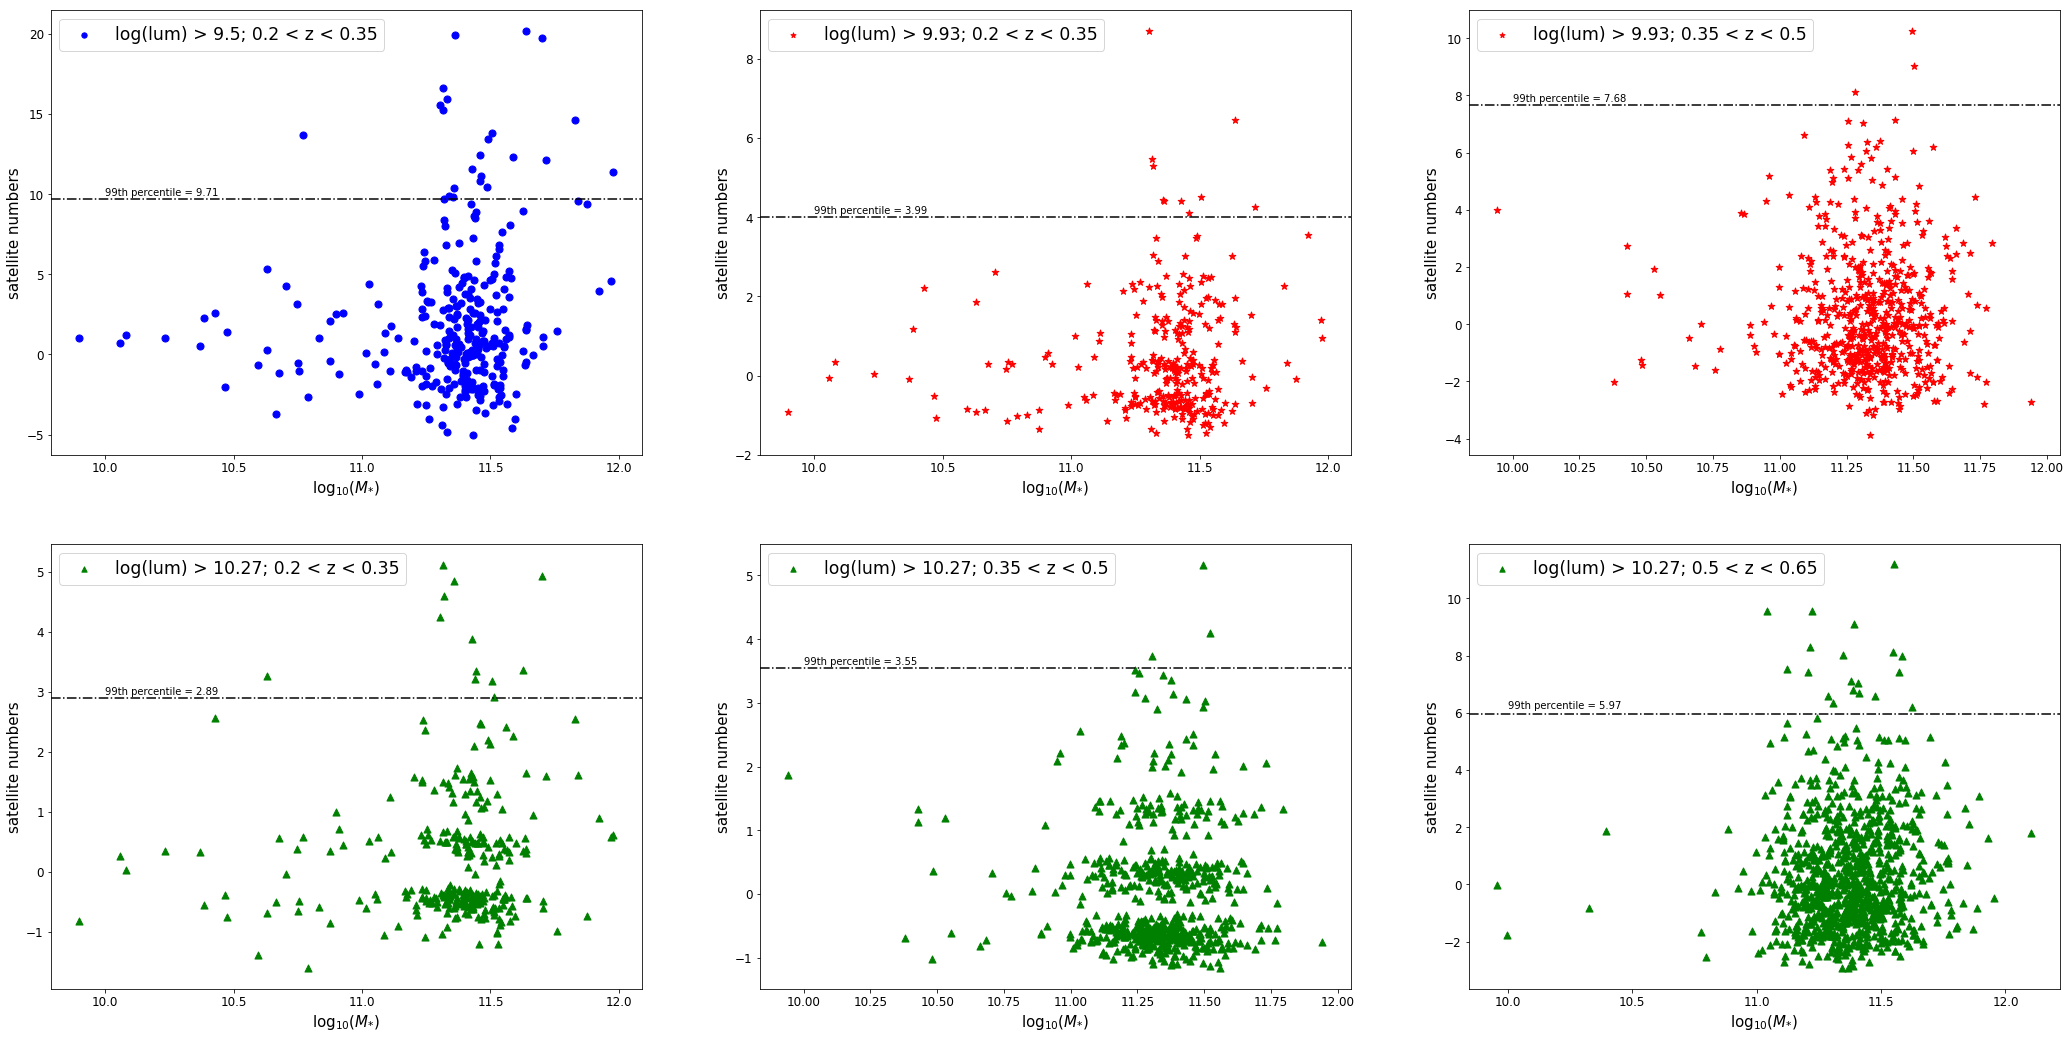

In [20]:
sumsat_low_35 = np.array([sumsat_low35]).flatten()

sumsat_mid_35 = np.array([sumsat_mid35]).flatten()
sumsat_mid_05 = np.array([sumsat_mid05]).flatten()

sumsat_high_35 = np.array([sumsat_high35]).flatten()
sumsat_high_05 = np.array([sumsat_high05]).flatten()
sumsat_high_65 = np.array([sumsat_high65]).flatten()
    
    
# plt.scatter(zLRG_low[sats_low35], sumsat_low_35[sats_low35], color='blue', marker='o', s=50, label='log(lum) > 9.5; 0.2 < z < 0.35')
# plt.legend(fontsize='xx-large', markerscale=0.75)
# plt.show()

# plt.scatter(zLRG_mid[sats_mid35], sumsat_mid_35[sats_mid35], color='red', marker='*', s=50, label='log(lum) > 9.93; 0.2 < z < 0.5')
# plt.scatter(zLRG_mid[sats_mid05], sumsat_mid_05[sats_mid05], color='red', marker='*', s=50)
# plt.legend(fontsize='xx-large', markerscale=0.75)
# plt.show()

# plt.scatter(zLRG_high[sats_high35], sumsat_high_35[sats_high35], color='green', marker='^', s=50, label='log(lum) > 10.27; 0.2 < z < 0.65')
# plt.scatter(zLRG_high[sats_high05], sumsat_high_05[sats_high05], color='green', marker='^', s=50)
# plt.scatter(zLRG_high[sats_high05], sumsat_high_05[sats_high05], color='green', marker='^', s=50)
# plt.legend(fontsize='xx-large', markerscale=0.75)
# plt.show()

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize = (36,18))

ax1.scatter(LRGmass_low, sumsat_low_35, color='blue', marker='o', s=50, label='log(lum) > 9.5; 0.2 < z < 0.35')
ax1.axhline(y=plow35[2], color='black', linestyle= '-.')
ax1.legend(fontsize='xx-large', markerscale=0.75, loc='upper left')
ax1.text(10., 9.9, '99th percentile = {}'.format(round(plow35[2],2), fontsize=50))
ax1.set_xlabel('$\log_{10}(M_{*})$', fontsize=15)
ax1.set_ylabel('satellite numbers', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
# plt.show()

ax2.scatter(LRGmass_low, sumsat_mid_35, color='red', marker='*', s=50, label='log(lum) > 9.93; 0.2 < z < 0.35')
ax2.axhline(y=pmid35[2], color='black', linestyle= '-.')
ax2.legend(fontsize='xx-large', markerscale=0.75, loc='upper left')
ax2.text(10., 4.1, '99th percentile = {}'.format(round(pmid35[2],2), fontsize=24))
ax2.set_xlabel('$\log_{10}(M_{*})$', fontsize=15)
ax2.set_ylabel('satellite numbers', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=12)
# plt.show()

ax3.scatter(LRGmass_mid, sumsat_mid_05, color='red', marker='*', s=50, label='log(lum) > 9.93; 0.35 < z < 0.5')
ax3.axhline(y=pmid05[2], color='black', linestyle= '-.')
ax3.legend(fontsize='xx-large', markerscale=0.75, loc='upper left')
ax3.text(10., 7.8, '99th percentile = {}'.format(round(pmid05[2],2), fontsize=24))
ax3.set_xlabel('$\log_{10}(M_{*})$', fontsize=15)
ax3.set_ylabel('satellite numbers', fontsize=15)
ax3.tick_params(axis='both', which='major', labelsize=12)
# plt.show()

ax4.scatter(LRGmass_low, sumsat_high_35, color='green', marker='^', s=50, label='log(lum) > 10.27; 0.2 < z < 0.35')
ax4.axhline(y=phigh35[2], color='black', linestyle= '-.')
ax4.legend(fontsize='xx-large', markerscale=0.75, loc='upper left')
ax4.text(10., 2.95, '99th percentile = {}'.format(round(phigh35[2],2), fontsize=24))
ax4.set_xlabel('$\log_{10}(M_{*})$', fontsize=15)
ax4.set_ylabel('satellite numbers', fontsize=15)
ax4.tick_params(axis='both', which='major', labelsize=12)
# plt.show()

ax5.scatter(LRGmass_mid, sumsat_high_05, color='green', marker='^', s=50, label='log(lum) > 10.27; 0.35 < z < 0.5')
ax5.axhline(y=phigh05[2], color='black', linestyle= '-.')
ax5.legend(fontsize='xx-large', markerscale=0.75, loc='upper left')
ax5.text(10., 3.6, '99th percentile = {}'.format(round(phigh05[2],2), fontsize=24))
ax5.set_xlabel('$\log_{10}(M_{*})$', fontsize=15)
ax5.set_ylabel('satellite numbers', fontsize=15)
ax5.tick_params(axis='both', which='major', labelsize=12)
# plt.show()

ax6.scatter(LRGmass_high, sumsat_high_65, color='green', marker='^', s=50, label='log(lum) > 10.27; 0.5 < z < 0.65')
ax6.axhline(y=phigh65[2], color='black', linestyle= '-.')
ax6.legend(fontsize='xx-large', markerscale=0.75, loc='upper left')
ax6.text(10., 6.15, '99th percentile = {}'.format(round(phigh65[2],2), fontsize=24))
ax6.set_xlabel('$\log_{10}(M_{*})$', fontsize=15)
ax6.set_ylabel('satellite numbers', fontsize=15)
ax6.tick_params(axis='both', which='major', labelsize=12)
# plt.show()

# plt.xlabel('redshift', fontsize=15)
# plt.ylabel('satellite numbers', fontsize=15)
# plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('/Users/mtownsend/Desktop/PaperPlots/sats_v_LRGmass.pdf')

plt.show()


